As detailed below, the first thing I do with the data is to import and clean it. Then, I one-hot encoded the gender variable, dropped the name, bib, ctz, the original gender variable, city, and state, and label encoded each country as a numeric value.

Because of the missing values in the split times, the split variables were object type. I converted each with pd.to_numeric function, coercing the errors to 'nan' values and then imputed the nan values as the mean of each column.

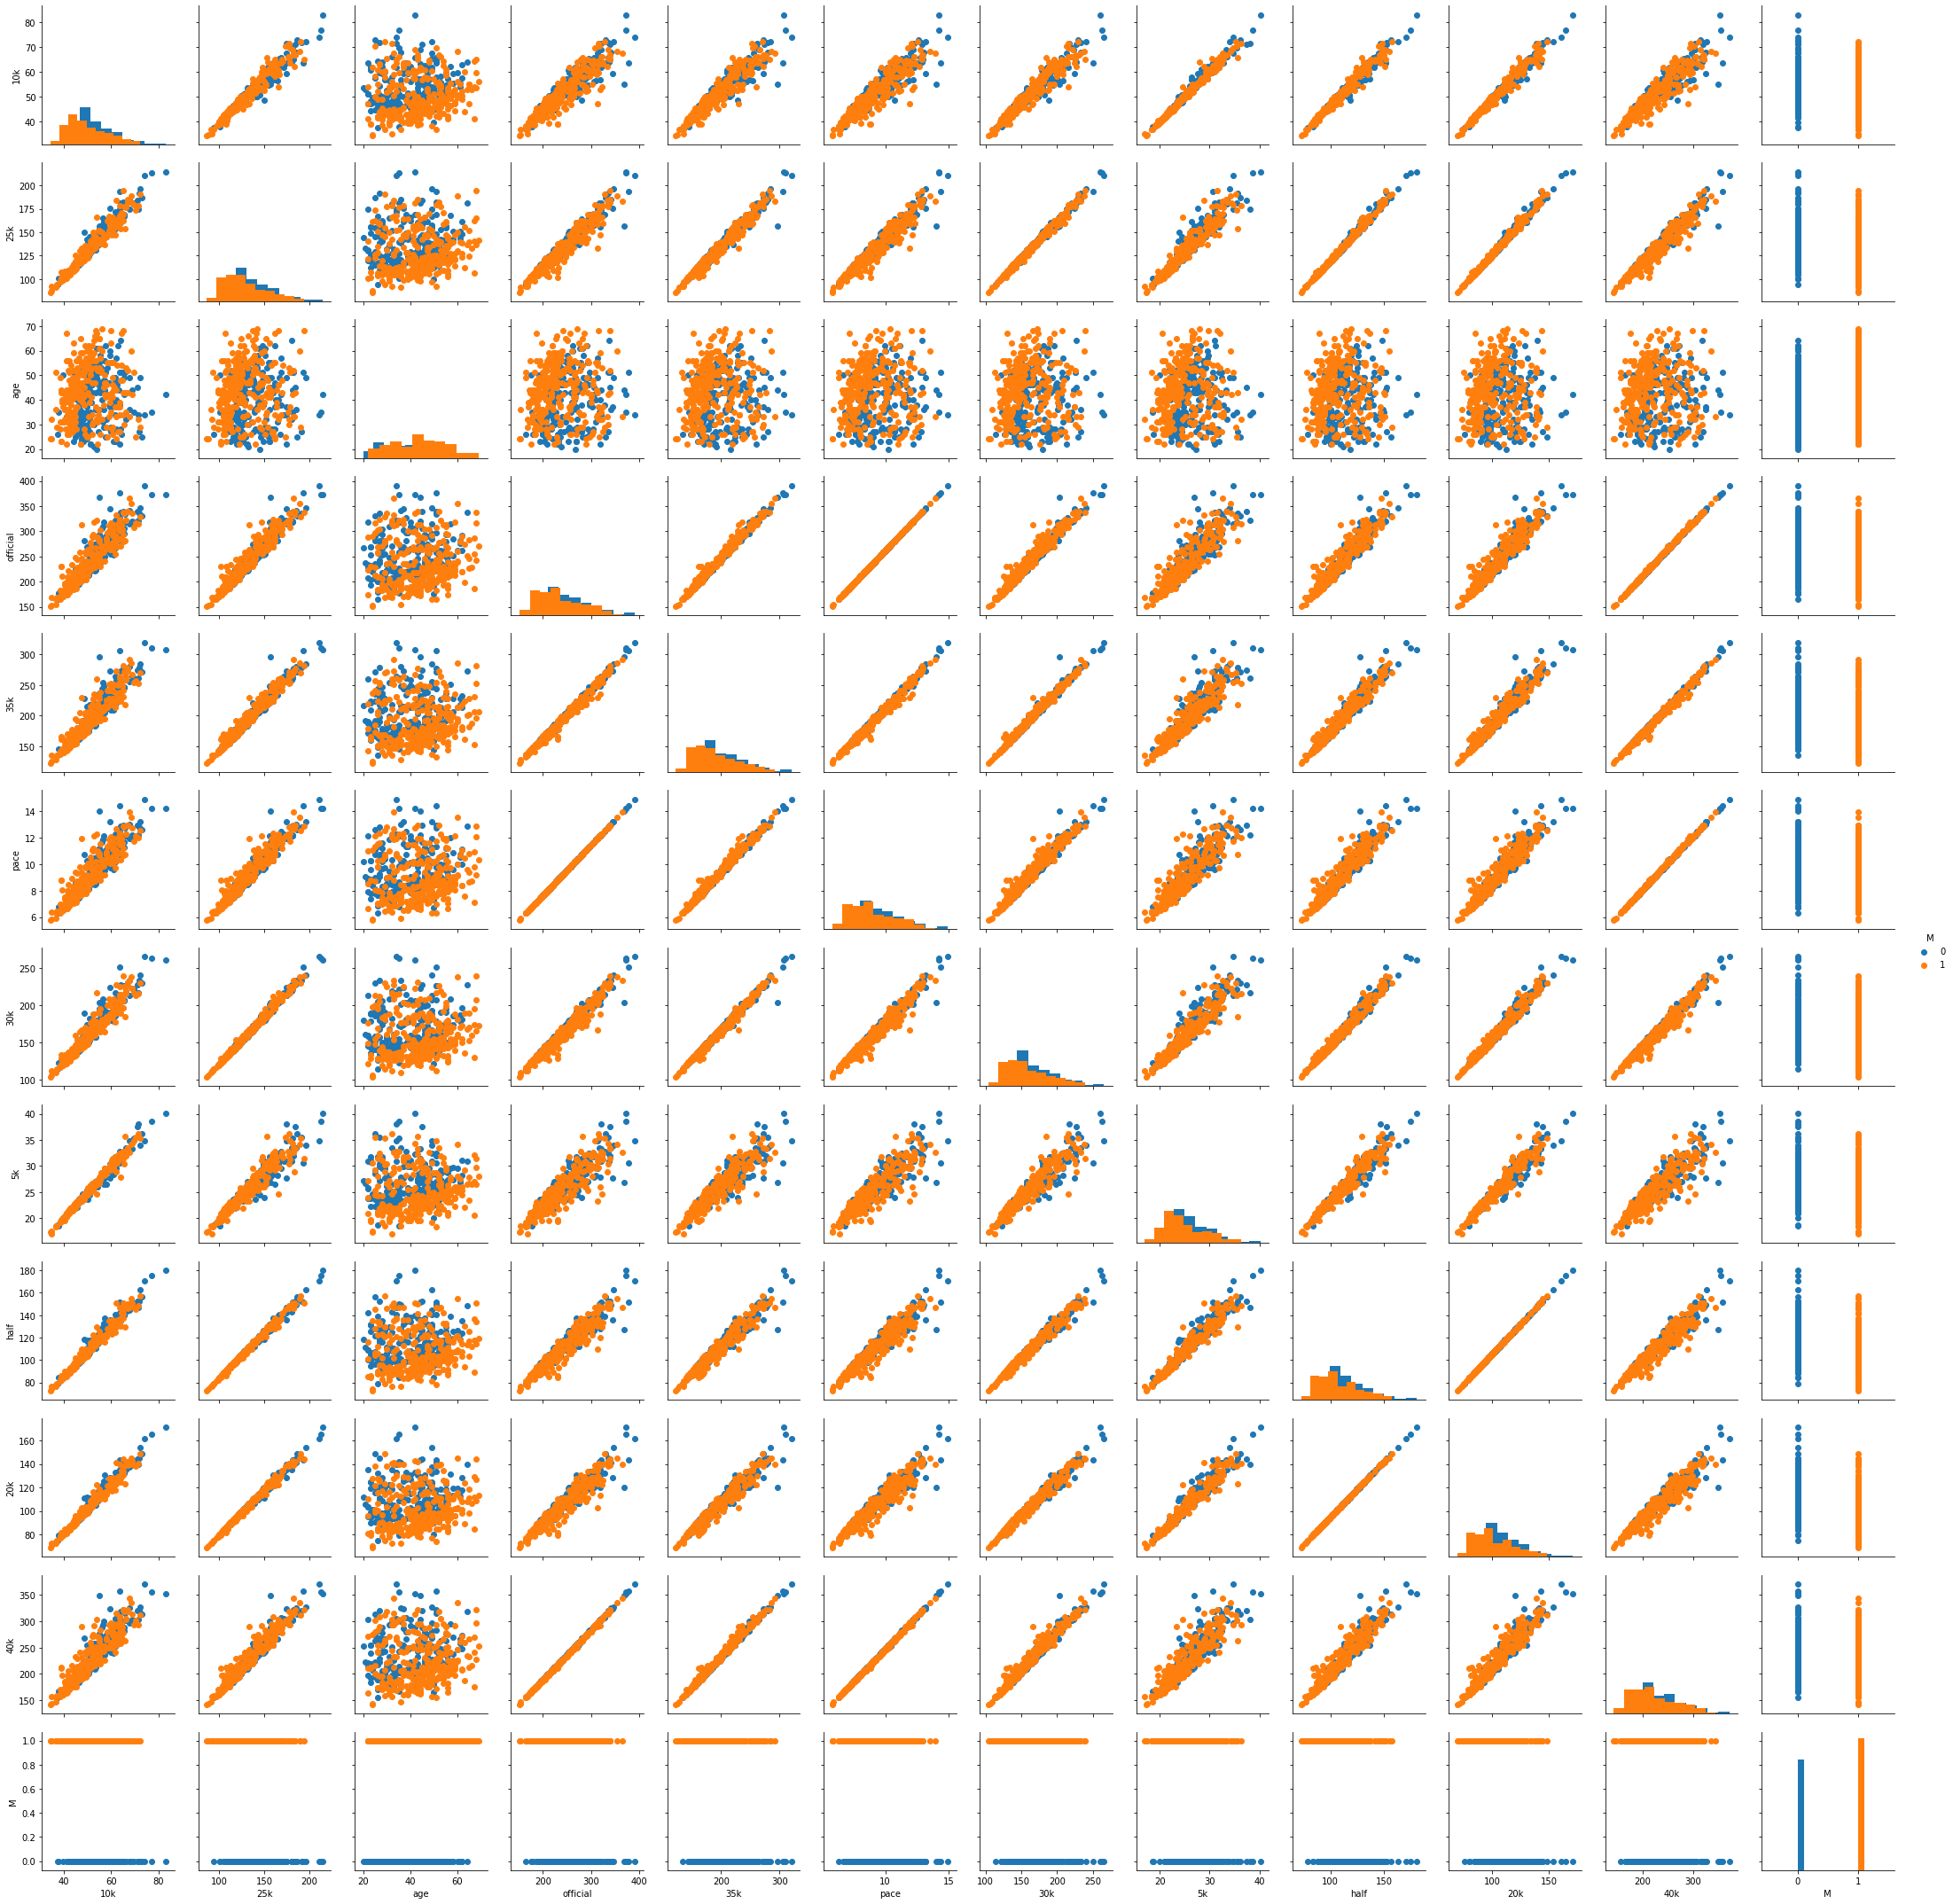

In [1]:
import numpy as np, pandas as pd, scipy, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

# Import data
data_path = ('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')
df = pd.read_csv(data_path)

# Fill nan strings with mean value for the variable
for var in ['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k']:
    df[var] = pd.to_numeric(df[var], errors='coerce')

# Convert gender to numeric with one-hot encoding, drop irrelevant object columns
df = pd.concat([df, pd.get_dummies(df['gender'], drop_first=True)], 1)
df = df.drop(['name', 'gender', 'bib', 'genderdiv', 'ctz',  'city', 
              'state', 'country', 'division', 'overall'], 1)

# This line lets us check for columns between the whole set, and male/female runners only
#df = df[df['M']==1]

# Limit the number of samples used
df = df.sample(n=500, random_state=42)
df = df.dropna(how='any')

# Create pairgrid to visualize univariate distributions and bivariate relationships
g = sns.PairGrid(df, hue='M')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()
plt.show()

Looking at the relationships in the data, it appears that most bivariate relationships have high correlation. We can also see that there appears to be significant overlap between genders. We'll note this later in our PCA-reduced model, but for now, we need to handle outliers prior to our models. 

In [2]:
# Using Tukey's method with 1.5 threshold, determine number of outliers in each column
for var in list(df.columns):
    q75, q25 = np.percentile(df[var], [75 ,25])
    iqr = q75 - q25
    threshold = 1.5
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("For: " + var)
    print("Number of outliers is: {}".format(len((np.where((df[var] > max_val) 
                                                           | (df[var] < min_val))[0]))
                                            ))
    print("Percentage of outliers is: {}\n".format(len((np.where((df[var] > max_val) 
                                                           | (df[var] < min_val))[0]))/df.shape[0]))

For: 10k
Number of outliers is: 3
Percentage of outliers is: 0.006048387096774193

For: 25k
Number of outliers is: 4
Percentage of outliers is: 0.008064516129032258

For: age
Number of outliers is: 0
Percentage of outliers is: 0.0

For: official
Number of outliers is: 6
Percentage of outliers is: 0.012096774193548387

For: 35k
Number of outliers is: 5
Percentage of outliers is: 0.010080645161290322

For: pace
Number of outliers is: 6
Percentage of outliers is: 0.012096774193548387

For: 30k
Number of outliers is: 5
Percentage of outliers is: 0.010080645161290322

For: 5k
Number of outliers is: 5
Percentage of outliers is: 0.010080645161290322

For: half
Number of outliers is: 4
Percentage of outliers is: 0.008064516129032258

For: 20k
Number of outliers is: 4
Percentage of outliers is: 0.008064516129032258

For: 40k
Number of outliers is: 6
Percentage of outliers is: 0.012096774193548387

For: M
Number of outliers is: 0
Percentage of outliers is: 0.0



In [3]:
# Create df without the gender column
y = df.drop('M', 1)

for var in list(y.columns):
    print("For: " + var)
    q75, q25 = np.percentile(df[var], [75 ,25])
    iqr = q75 - q25
    threshold = 1.5
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    
    ol = len(np.where((df[var] > max_val) | (df[var] < min_val))[0])
    otl_perc = ol/df.shape[0]
    
    # Drops outliers if variable total is less than 1%
    if otl_perc < 0.025:
        df = df[df[var]<max_val]
        df = df[df[var]>min_val]
        ol = len(np.where((df[var] > max_val) | (df[var] < min_val))[0])
        #otl_perc = ol/df.shape[0]
        
    print("Number of Rows: {}".format(df.shape[0]))
    print("Number of outliers is: {}".format(ol))
    #print("Percentage of outliers is: {}".format(otl_perc))

For: 10k
Number of Rows: 493
Number of outliers is: 0
For: 25k
Number of Rows: 491
Number of outliers is: 0
For: age
Number of Rows: 491
Number of outliers is: 0
For: official
Number of Rows: 488
Number of outliers is: 0
For: 35k
Number of Rows: 488
Number of outliers is: 0
For: pace
Number of Rows: 488
Number of outliers is: 0
For: 30k
Number of Rows: 487
Number of outliers is: 0
For: 5k
Number of Rows: 483
Number of outliers is: 0
For: half
Number of Rows: 482
Number of outliers is: 0
For: 20k
Number of Rows: 482
Number of outliers is: 0
For: 40k
Number of Rows: 482
Number of outliers is: 0


It looks like the outliers account for about 5% of the data. Normally this would be a slightly higher than we like but since this is just a sample of the overall data, we can accept it as we can always add in additional data to get a more complete distribution 

[63.99 96.24]


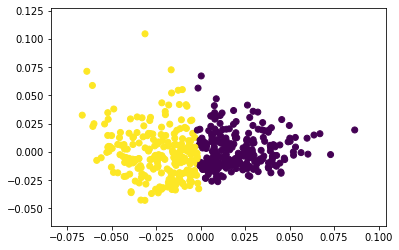

col_0    0    1
M              
0       95  122
1      159  106


In [4]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Define features and outcome
X = df.iloc[:, :11]
y = df.iloc[:, 11]

# Normalize our features and fit model with full feature set
X_norm = normalize(X)
y_pred = KMeans(n_clusters=2, random_state=0).fit_predict(X_norm)

# Reduce with PCA for plotting purposes
pca = PCA(2)
X_pca = pca.fit_transform(X_norm)
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

print(pd.crosstab(y, y_pred))

For my first K-Means model, the graphic representation of our two PCA components looks like the model is performing well. However, the choice to bifurcate the data based on gender appears to have no correlation to the clusters that the identified. I suspect that as there is likely a huge overlap in distribution between the male and female runners. K-Means will likely be one of our poorer performers based on this, since it's likely that there's no useful information which would allow the data to split on the basis of gender. Now we evaluate the performance of the two cluster model using Adjusted Rand Index:

In [5]:
import itertools
from sklearn import metrics

c = list(itertools.product(y, y_pred))
RIcounts = [c.count(x) for x in set(c)]
RIscore = (RIcounts[3] + RIcounts[2]/np.sum(RIcounts))
print("Rand Score: {}".format(RIscore))
print("Adjusted Rand Score: {}".format(metrics.adjusted_rand_score(y, y_pred)))

Rand Score: 60420.23724625954
Adjusted Rand Score: 0.0255195965359465


As we can see from the Rand Score, the model is very close to random, which helps confirm what our crosstab produced.

Number of estimated clusters: 7


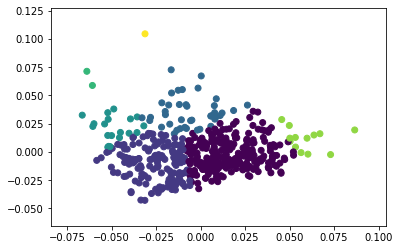

Comparing the assigned categories to the ones in the data:
col_0    0   1   2   3  4   5  6
M                               
0      104  92  13   7  0   1  0
1      154  57  27  12  2  12  1


In [6]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X_norm, quantile=.1, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X_norm)
cluster_preds = ms.fit_predict(X_norm)

labels = ms.labels_
cluster_centers = ms.cluster_centers_

n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y, labels))

With mean shift, the model identified only two clusters with a bandwidth of 0.25. For comparison, decreasing the bandwidth to .1 increased the number of clusters to 7 which appears to more naturally cluster the data points, versus the one dimensional separation observed within the k-means model. Again, there appears to be no correlation (or at least a very weak one) between these clusters and the runner's gender, which leads me to conclude that the model doesn't identify gender as a feature worth clustering the data around.

In [7]:
import itertools
from sklearn import metrics

c = list(itertools.product(y, cluster_preds))
RIcounts = [c.count(x) for x in set(c)]
RIscore = (RIcounts[3] + RIcounts[2]/np.sum(RIcounts))
print("Rand Score: {}".format(RIscore))
print("Adjusted Rand Score: {}".format(metrics.adjusted_rand_score(y, cluster_preds)))

Rand Score: 55986.02167231969
Adjusted Rand Score: 0.024796656054436768


Again, we see that the mean shift model is randomly assigning datapoints. Because we let the model identify the number of clusters based on bandwidth, we can make the assumption that it is drawing out more natural patterns in the data than an arbitrary bisection based on gender.

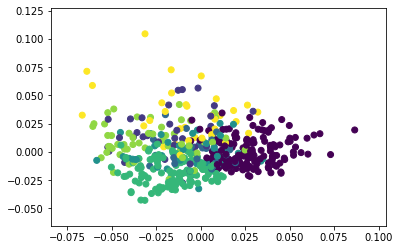

Comparing the assigned categories to the ones in the data:
col_0    0   1   2   3   4   5   6
M                                 
0       55  15  10  30  75  28   4
1      110  16  16  17  47  25  34


In [8]:
from sklearn.cluster import SpectralClustering

# Declare and fit the model.
sc = SpectralClustering(n_clusters=7)
sc.fit(X_norm)

#Predicted clusters.
predict=sc.fit_predict(X_norm)

#Graph results.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y, predict))

Spectral clustering demonstrates its ability to identify clusters with non-flat geometry, as many of the points identified in each cluster have overlap with other clusters in our 2 dimensional plot. The fact that it is able to identify overlapping clusters may indicate that spectral clustering is better suited to idenify if there are notable differences between male and female runners, although the results of crosstab indicate this is not necessarily the case.

Estimated number of clusters: 23


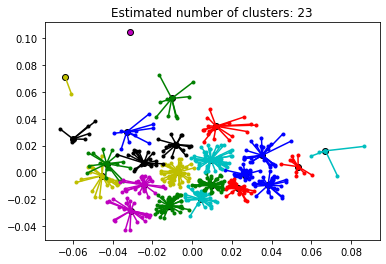

In [9]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare and fit the model
af = AffinityPropagation().fit(X_norm)

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = itertools.cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_pca[cluster_centers_indices[k]]
    plt.plot(X_pca[class_members, 0], X_pca[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_pca[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

Affinity propagation appears to perform quite well. Because of the high dimensionality in the original data, the model can produce exemplars which easily represent the members of the cluster.

Based on the models and selected evaluation techniques, I conclude that gender is a poor feature to try and derive features from. We can confirm this based on the distributions plotted at the top of the assignment, but we could also allow the clusters to stand on their own, as they may provide additional information on the division of the data.